In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import statistics as stat

from scipy import special, optimize

---
---
# Fit viscosity measurements

In [57]:
filename = "./experimentdata.csv";
df_data = pd.read_csv(filename, sep=',');
display(df_data.head())

,Shear rate 1/s,Viscosity Pa.s
0,0.031416,3376.02
1,0.062832,3296.92
2,0.125664,3150.91
3,0.251328,3010.33
4,0.376992,2853.87


### The Carreau-Yasuda Model [1]
### $$ \frac{\eta - b}{a - b} = \frac{1}{\left[1 + \left(c \dot{\gamma}\right)^e\right]^{\frac{1 - d}{e}}} $$
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [4]:
def CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    e = m;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**e;
    expo = (1 - d)/e;
    deno = base**expo;
    
    return (nume/deno) + b;

---
## Compute fitting curve with the Carreau-Yasuda model

In [5]:
# plot fitting
gamma    = np.logspace(-3, 5, 100)
eta_zero = 3679
eta_inft = 5.25439
kappa    = 0.0379711
n        = 0.127674
m        = 0.446226

df = pd.DataFrame()
df['Shear rate fit'] = pd.Series(gamma)
df['Viscosity fit'] = pd.Series(CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m))

display(df)

,Shear rate fit,Viscosity fit
0,0.001000,3603.685768
1,0.001205,3597.275638
2,0.001451,3590.330115
3,0.001748,3582.806287
4,0.002105,3574.658127
...,...,...
95,47508.101621,10.211429
96,57223.676594,9.491179
97,68926.121043,8.874096
98,83021.756813,8.345716


---
## Plot data and fitted curves

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

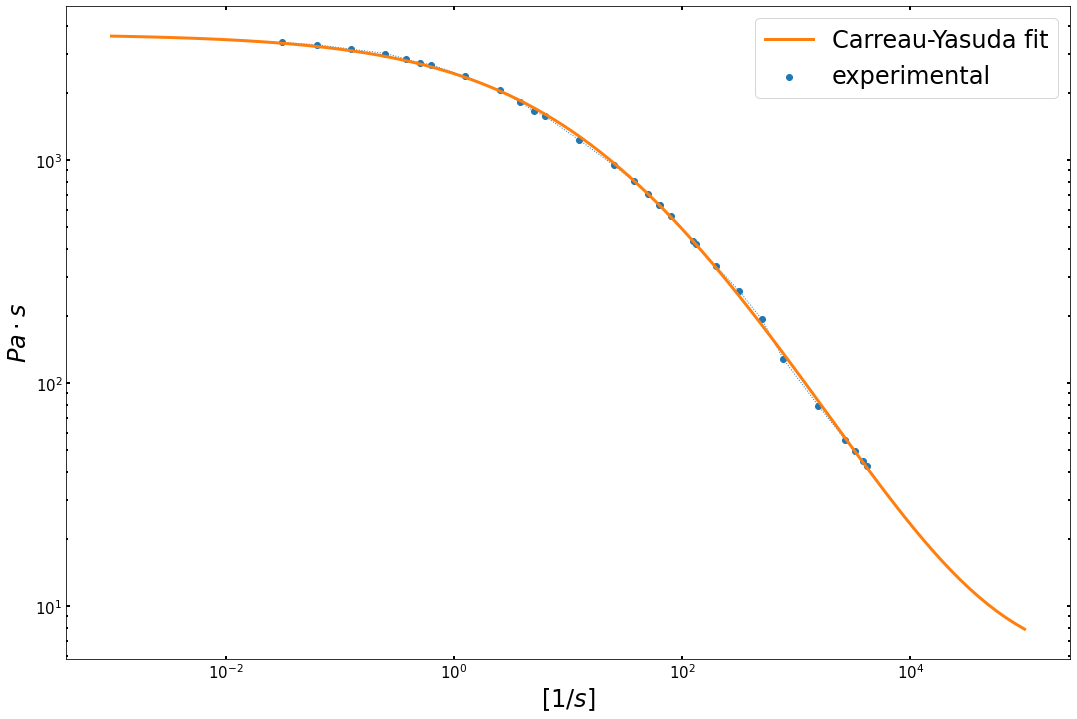

In [6]:
# Draw plot canvas
plotname = "Experiment Data"
scale = 6
plt.subplots(figsize=(3*scale, 2*scale))
ax0 = plt.gca()

# plot dataset
x = pd.Series(df_data['Shear rate 1/s']).dropna()
y = pd.Series(df_data['Viscosity Pa.s']).dropna()
plt.scatter(x, y, label='experimental')
plt.plot(x, y, linewidth=1, linestyle=':')

# plot fitting
x_fit = df['Shear rate fit']
y_fit = df['Viscosity fit']
plt.plot(x_fit, y_fit, linewidth=3, label='Carreau-Yasuda fit');

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('log');
plt.xscale('log');
plt.xlabel(r'$[1/s]$', fontsize=24);
plt.ylabel(r'$Pa \cdot s$', fontsize=24);
#plt.title(plotname, size=24);
plt.legend(prop={'size': 24});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
# Shear viscosity as a function of a given shear rate $\dot{\gamma}_o$
# $$ \eta (t, \dot{\gamma}_o) = f_1 \sum_{1=1}^{n} \frac{a_i}{{\alpha_i}^2} \left( 1 - e^{1 - \alpha_i t} (1 - \dot{\gamma}_o n_1 \lambda_i \alpha_i t) \right) +
                                f_2 \sum_{1=1}^{n} \frac{a_i}{{\beta_i}^2}  \left( 1 - e^{1 - \beta_i  t} (1 - \dot{\gamma}_o n_2 \lambda_i \beta_i  t) \right) $$
 
### where:
### $$ f_2 = 1 - f_1 $$
### $$ \alpha_i = \frac{1 + n_1 \lambda_i \dot{\gamma}_o}{\lambda_i} $$
### $$ \beta_i  = \frac{1 + n_2 \lambda_i \dot{\gamma}_o}{\lambda_i} $$
$\eta (t, \dot{\gamma}_o) =$ shear viscosity <br>
$t =$ time <br>
$\dot{\gamma}_o =$ shear rate <br>
$a_i =$ the $i^{th}$ elastic value of the Maxwell element <br>
$\lambda_i =$ the $i^{th}$ characteristic time of the Maxwell element <br>
$f_1, f_2, n_1, n_2$ are fitting parameters

In [7]:
dot_gamma_o = 1 # make it global

# Let's model with 8 Maxwell elements
def _eta_gamma(t, *p):
    a_          = p[0:8]
    lambda_     = p[8:16]
    f_1         = p[16]
    f_2         = 1 - f_1
    n_1         = p[17]
    n_2         = p[18]
    
    sum_1 = 0
    for i in range(0, 8, 1):
        alpha = _alpha(n_1, lambda_[i], dot_gamma_o)
        frac = a_[i] / alpha**2
        expo = np.exp(- alpha*t)
        prod = dot_gamma_o*n_1*lambda_[i]*alpha*t
        res_1 = frac*(1 - expo * (1 - prod))
        sum_1 = sum_1 + res_1
        
    sum_2 = 0
    for i in range(0, 8, 1):
        beta  = _beta(n_2, lambda_[i], dot_gamma_o)
        frac = a_[i] / beta**2
        expo = np.exp(- beta*t)
        prod = dot_gamma_o*n_2*lambda_[i]*beta*t
        res_2 = frac*(1 - expo * (1 - prod))
        sum_2 = sum_2 + res_2
    
    res = (f_1 * sum_1) + (f_2 * sum_2)
    
    return res/10

def _alpha(n_1, lambda_, dot_gamma_o):
    nume = 1 + n_1*lambda_*dot_gamma_o
    deno = lambda_
    res = nume / deno
    return res

def _beta(n_2, lambda_, dot_gamma_o):
    nume = 1 + n_2*lambda_*dot_gamma_o
    deno = lambda_
    res = nume / deno
    return res

# The Wagner model gives the shear viscosity vs. time of a single shear rate ...
## now let's caculate the steady state shear viscocity at several shear rates at $t = \infty$
## $$ \eta (t = \infty, \dot{\gamma}_o) = f_1 \sum_{1=1}^{n} \frac{a_i}{{\alpha_i}^2} +
                                 f_2 \sum_{1=1}^{n} \frac{a_i}{{\beta_i}^2} $$

In [8]:
def _eta_infty(dot_gamma, *p):
    a_          = p[0:8]
    lambda_     = p[8:16]
    f_1         = p[16]
    f_2         = 1 - f_1
    n_1         = p[17]
    n_2         = p[18]
    
    sum_1 = 0
    for i in range(0, 8, 1):
        alpha = _alpha(n_1, lambda_[i], dot_gamma)
        res_1 = a_[i] / alpha**2
        sum_1 = sum_1 + res_1
        
    sum_2 = 0
    for i in range(0, 8, 1):
        beta  = _beta(n_2, lambda_[i], dot_gamma)
        res_2 = a_[i] / beta**2
        sum_2 = sum_2 + res_2
    
    res = (f_1 * sum_1) + (f_2 * sum_2)
    
    return res/10

---
## Compute fitting curve with the Wagner model (and plot)

In [9]:
def _fit_eta(t, eta):    
    # Initial guess
    ai      = [0.0000006, 0.0003, 0.28, 30, 10000, 2000000, 40000000, 200000000]
    lambdai = [3000, 600, 100, 10, 1, 0.1, 0.01, 0.001]
    f1 = [0.57]
    n1 = [2.8]
    n2 = [0.07]
    p = ai + lambdai + f1 + n1 + n2
    
    # Fit the model
    upbound    = [np.inf]*16 + [1] + [np.inf]*2
    model      = optimize.curve_fit(_eta_infty, t, eta, p, bounds=(0, upbound)); #bounds=(0, [3., 1., 0.5])
    parameters = model[0]

    # Show the fitting parameters
    print(parameters)
    
    return parameters

---
## plot the Wagner fit and get $n_1$, $n_2$

[3.96453361e-07 1.78460749e-04 1.46700609e-01 5.07620566e+01
 1.01527929e+04 1.88475089e+06 2.67036501e+07 2.12078861e+08
 2.22611145e+03 4.01589068e+02 5.10605560e+01 1.50384175e-01
 1.00911954e+00 9.64964058e-02 1.31382820e-02 3.05545551e-03
 6.69494901e-01 1.71085954e+00 6.80393423e-02]


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

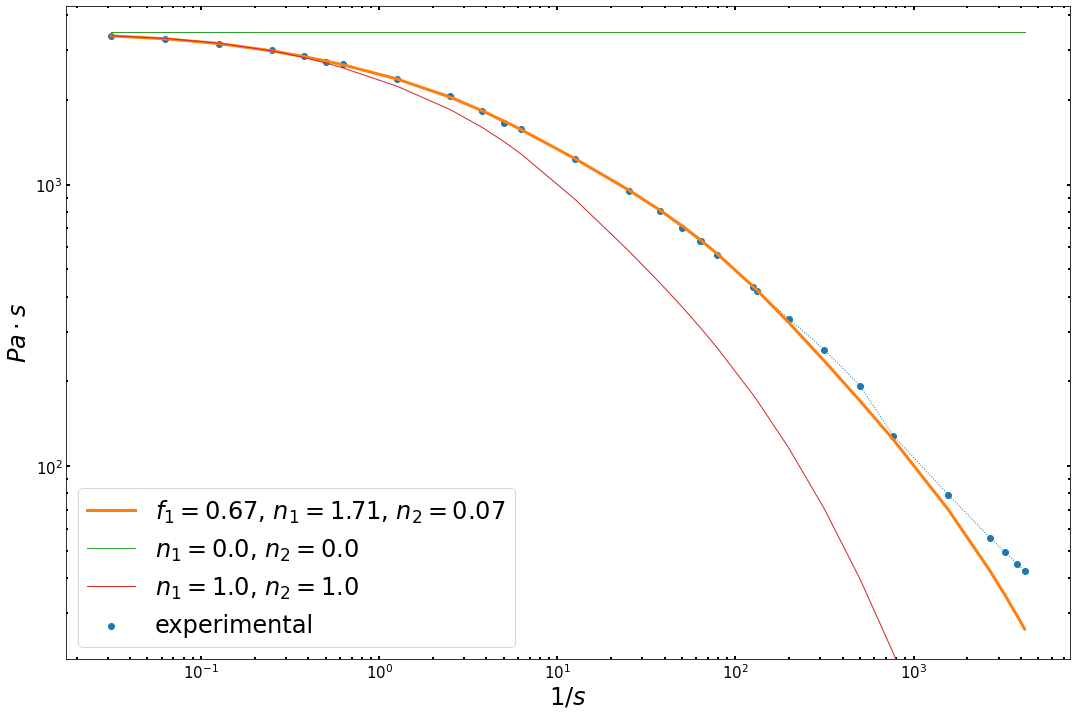

In [10]:
parameters = _fit_eta(
    pd.Series(df_data['Shear rate 1/s']).dropna(),
    pd.Series(df_data['Viscosity Pa.s']).dropna())

# Draw plot canvas
scale = 6;
plotname = 'Wagner fit';
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()
    
# plot dataset
t   = pd.Series(df_data['Shear rate 1/s']).dropna()
eta = pd.Series(df_data['Viscosity Pa.s']).dropna()
plt.scatter(t, eta, label='experimental')
plt.plot(t, eta, linewidth=1, linestyle=':')
    
# Plot fit
n_1 = parameters[17]
n_2 = parameters[18]
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$f_1 = $' + str(round(parameters[16],2)) + ', ' +
         r'$n_1 = $' + str(round(n_1, 2)) + ', ' +
         r'$n_2 = $' + str(round(n_2, 2)));

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('log');
plt.xscale('log');

ax0.set(autoscale_on=False)
parameters[17] = 0
parameters[18] = 0
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=1, label = r'$n_1 = $' + str(round(parameters[17],2)) + ', ' +
         r'$n_2 = $' + str(round(parameters[18],2)));
parameters[17] = 1
parameters[18] = 1
eta_fit = _eta_infty(t, *parameters)
plt.plot(t, eta_fit, linewidth=1, label = r'$n_1 = $' + str(round(parameters[17],2)) + ', ' +
         r'$n_2 = $' + str(round(parameters[18],2)));

# save the ns
parameters[17] = n_1
parameters[18] = n_2

plt.xlabel(r'$1/s$', fontsize=24);
plt.ylabel(r'$Pa \cdot s$', fontsize=24);
#plt.title(plotname, size=24);
plt.legend(prop={'size': 24});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
# 1.a) Obtain the Transient Shear Viscosity at 1, 10 and 100 1/s

[3.96453361e-07 1.78460749e-04 1.46700609e-01 5.07620566e+01
 1.01527929e+04 1.88475089e+06 2.67036501e+07 2.12078861e+08
 2.22611145e+03 4.01589068e+02 5.10605560e+01 1.50384175e-01
 1.00911954e+00 9.64964058e-02 1.31382820e-02 3.05545551e-03
 6.69494901e-01 1.71085954e+00 6.80393423e-02]


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

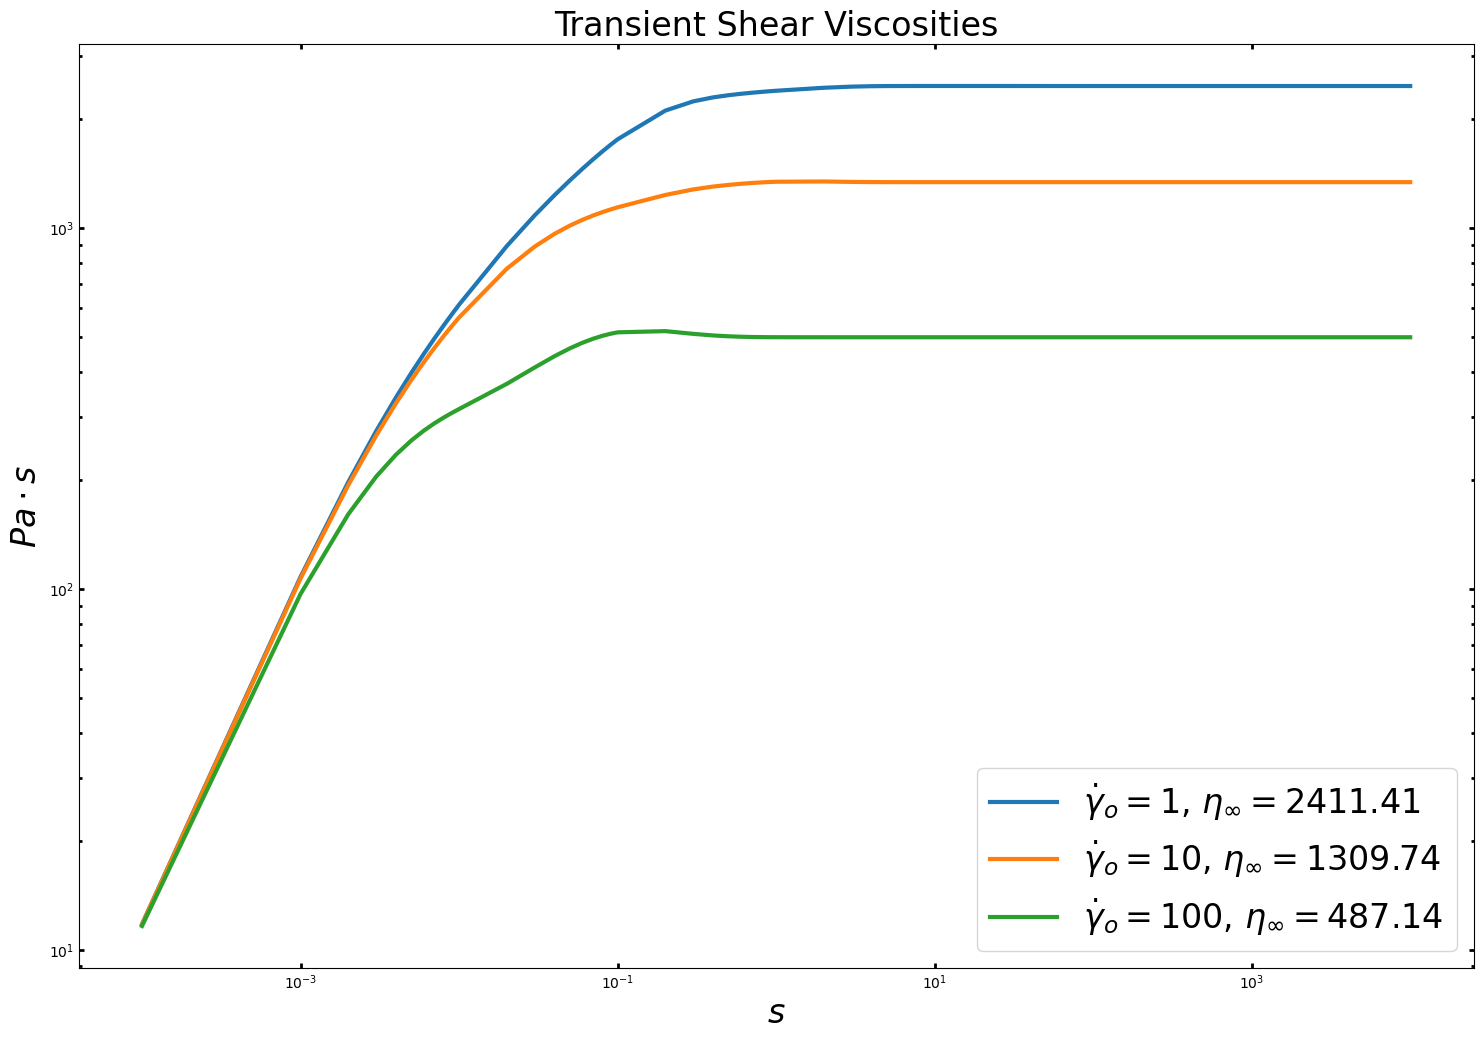

In [42]:
parameters = _fit_eta(
    pd.Series(df_data['Shear rate 1/s']).dropna(),
    pd.Series(df_data['Viscosity Pa.s']).dropna())

# Draw plot canvas
scale = 6;
plotname = 'Transient Shear Viscosities';
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()
    
# Plot fit
dot_gamma_o = 1
eta_fit = _eta_gamma(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$\dot{\gamma}_o = $' + str(dot_gamma_o) + ", " +
         r'$\eta_{\infty} = $' + str(round(_eta_infty(dot_gamma_o, *p),2)));
dot_gamma_o = 10
eta_fit = _eta_gamma(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$\dot{\gamma}_o = $' + str(dot_gamma_o) + ", " +
         r'$\eta_{\infty} = $' + str(round(_eta_infty(dot_gamma_o, *p),2)));
dot_gamma_o = 100
eta_fit = _eta_gamma(t, *parameters)
plt.plot(t, eta_fit, linewidth=3, label = r'$\dot{\gamma}_o = $' + str(dot_gamma_o) + ", " +
         r'$\eta_{\infty} = $' + str(round(_eta_infty(dot_gamma_o, *p),2)));

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('log');
plt.xscale('log');
plt.xlabel(r'$s$', fontsize=24);
plt.ylabel(r'$Pa \cdot s$', fontsize=24);
plt.title(plotname, size=24);
plt.legend(prop={'size': 24});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
# Steady state first normal stress difference $N1$ at $t = \infty$
### $$ N1(t, \dot{\gamma}_o) = {\dot{\gamma}_o}^2 \left\{ f_1 \sum_{i=1}^{n} a_i {\alpha_i}^3 \left( 1 - e^{- \alpha_i t} \left[ 1 + \alpha_i t - {\alpha_i}^2 \left( n_1 \lambda_i \frac{\dot{\gamma}_o}{2} \right) t^2 \right) \right] + f_2 \sum_{i=1}^{n} a_i {\beta_i}^3 \left( 1 - e^{- \beta_i t} \left[ 1 + \beta_i t - {\beta_i}^2 \left( n_2 \lambda_i \frac{\dot{\gamma}_o}{2} \right) t^2 \right) \right] \right\} $$
### $$ N1(t=\infty, \dot{\gamma}_o) = {\dot{\gamma}_o}^2 \left\{ f_1 \sum_{i=1}^{n} a_i {\alpha_i}^3 + f_2 \sum_{i=1}^{n} a_i {\beta_i}^3 \right\} $$

In [52]:
def _N1(dot_gamma, *p):
    a_          = p[0:8]
    lambda_     = p[8:16]
    f_1         = p[16]
    f_2         = 1 - f_1
    n_1         = p[17]
    n_2         = p[18]
    
    sum_1 = 0
    for i in range(0, 8, 1):
        alpha = _alpha(n_1, lambda_[i], dot_gamma)
        res_1 = a_[i] * (alpha**3)
        sum_1 = sum_1 + res_1
        
    sum_2 = 0
    for i in range(0, 8, 1):
        beta  = _beta(n_2, lambda_[i], dot_gamma)
        res_2 = a_[i] * (beta**3)
        sum_2 = sum_2 + res_2
    
    res = dot_gamma**2 * (f_1*sum_1 + f_2*sum_2)
    
    return res

---
# 1.b) Obtain the steady state first normal stress dfference

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

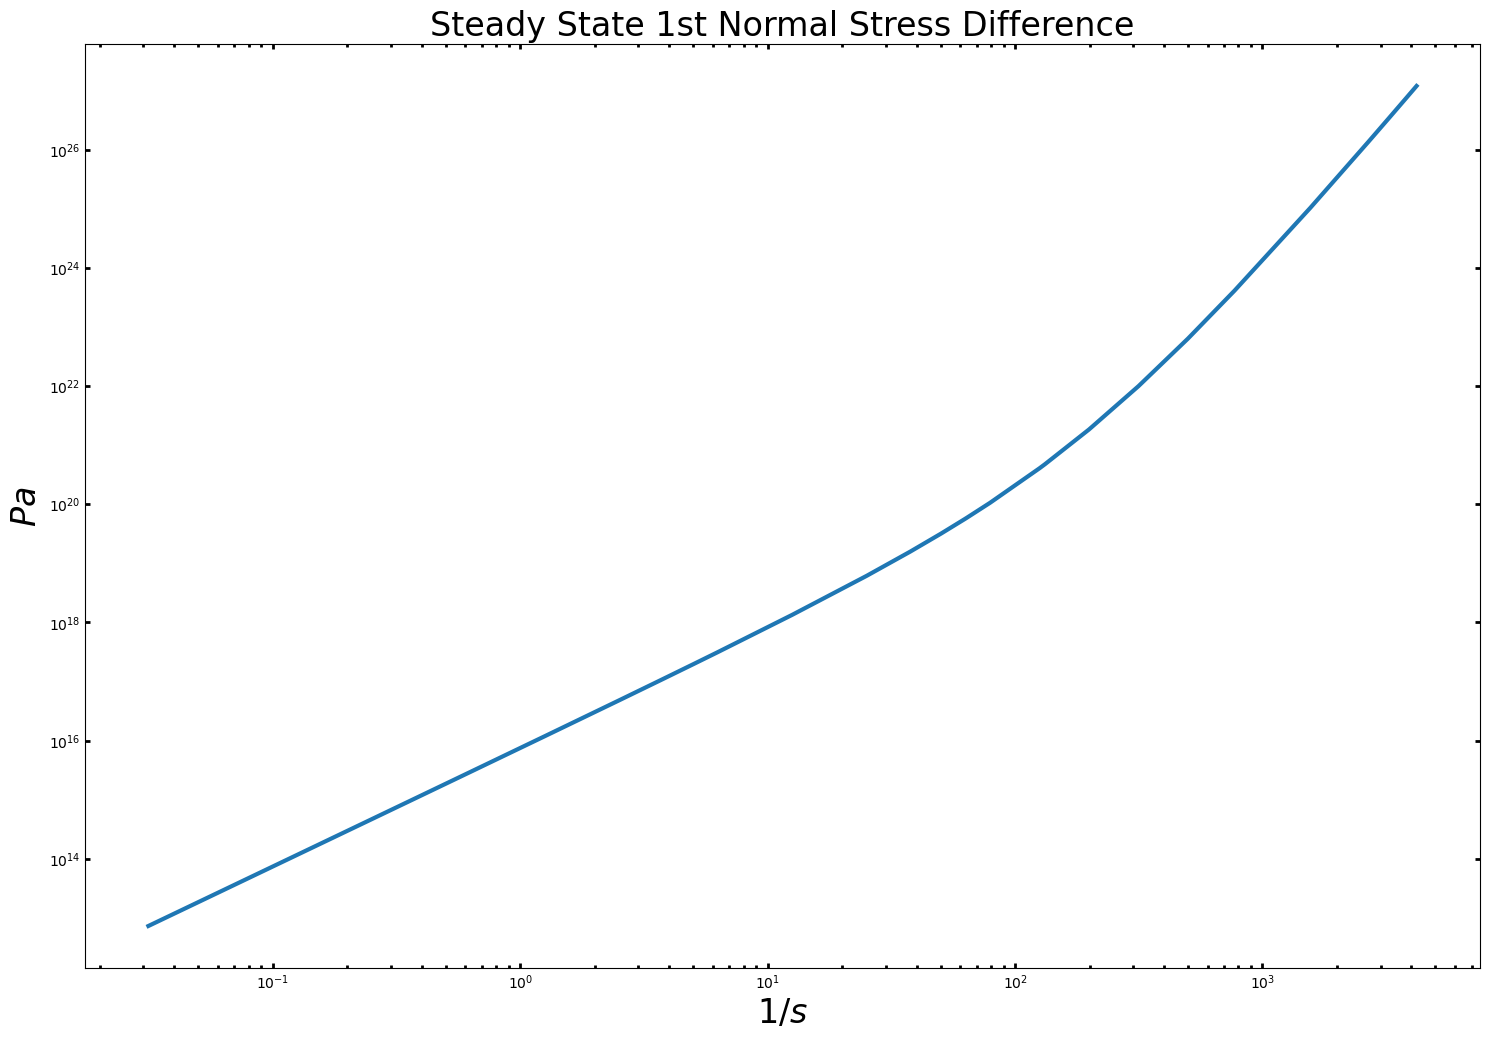

In [56]:
# Draw plot canvas
scale = 6;
plotname = 'Steady State 1st Normal Stress Difference';
plt.subplots(figsize=(3*scale, 2*scale));
ax0 = plt.gca()

# Plot fit
gamma = pd.Series(df_data['Shear rate 1/s']).dropna()
N1 = _N1(gamma, *parameters)
plt.plot(gamma, N1, linewidth=3);

# Format and Display plots
ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
plt.yscale('log');
plt.xscale('log');
plt.xlabel(r'$1/s$', fontsize=24);
plt.ylabel(r'$Pa$', fontsize=24);
plt.title(plotname, size=24);
#plt.legend(prop={'size': 24});
plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
display(plt);

---
# PlayGround Cell

0        7.985329
1       71.636437
2      131.458189
3      184.863895
4      234.025973
         ...     
60    3625.601661
61    3625.601627
62    3625.601612
63    3625.601606
64    3625.601603
Length: 65, dtype: float64

3625.6016016878507


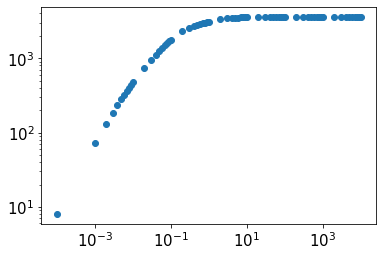

In [12]:
t       = pd.Series([0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
ai      = [0.00000006, 0.00003, 0.028, 30, 10000, 2000000, 40000000, 200000000]
lambdai = [3000, 600, 100, 10, 1, 0.1, 0.01, 0.001]
f1 = [0.57]
n1 = [2.8]
n2 = [0.07]

p = ai + lambdai + f1 + n1 + n2

dot_gamma_o = 0.01 # make it global
eta_gamma = _eta_gamma(t, *p)
eta_steady = _eta_infty(dot_gamma_o, *p)
display(eta_gamma)
print(eta_steady)

plt.scatter(t, eta_gamma)
plt.yscale('log')
plt.xscale('log')

In [13]:
# Recover matplotlib defaults
mpl.rcParams.update(mpl.rcParamsDefault);